In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")
from ai4material_design.scripts.summary_table_lean import read_trial
from ai4material_design.ai4mat.data.data import StorageResolver

In [7]:
targets = ["formation_energy_per_site"]
results = []
with open("../scripts/ASPIRE-1/MoS2_V2_E.txt", "rt") as definitions_file:
    for line in definitions_file:
        trial, target, n_repeats, _, experiment = line.strip().split()
        for i in range(1, int(n_repeats) + 1):
            these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
            these_results["trial_family"] = trial
            these_results["trial_index"] = i
            results.append(these_results)

In [8]:
results_pd = pd.concat(results, axis=0)

In [66]:
folded_predictions = results_pd.loc[
    ("formation_energy_per_site", "combined"),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()

/tmp/ipykernel_19713/2301786316.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  folded_predictions = results_pd.loc[


In [67]:
folded_predictions

trial_family                         trial_index
schnet/25-11-2022_16-52-31/71debf15  1              _id
6141cf1202d926221cabc545    4.117627
6141c...
                                     2              _id
6141cf1202d926221cabc545    4.135865
6141c...
                                     3              _id
6141cf1202d926221cabc545    4.131467
6141c...
                                     4              _id
6141cf1202d926221cabc545    4.122918
6141c...
                                     5              _id
6141cf1202d926221cabc545    4.102203
6141c...
                                                                          ...                        
megnet_pytorch/full/base             8              _id
6141cf1202d926221cabc545    4.018864
6141c...
                                     9              _id
6141cf1202d926221cabc545    4.037397
6141c...
                                     10             _id
6141cf1202d926221cabc545    4.429689
6141c...
                                 

In [78]:
predictions_list = []
for (trail_family, trial_index), these_predictions in folded_predictions.items():
    prediction_frame = these_predictions.to_frame()
    prediction_frame["trial_family"] = trail_family
    prediction_frame["trial_index"] = trial_index
    prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
    predictions_list.append(prediction_frame.squeeze())

In [79]:
predictions_pd = pd.concat(predictions_list, axis=0)

In [91]:
predictions_pd.groupby(level=["trial_family", "_id"]).mean()

trial_family                           _id                     
catboost/29-11-2022_13-16-01/02e5eda9  6141cf1202d926221cabc545    4.129552
                                       6141cf1302d926221cabc547    4.130158
                                       6141cf1302d926221cabc549    4.159167
                                       6141cf1502d926221cabc54b    3.982982
                                       6141cf1602d926221cabc54d    4.140147
                                                                     ...   
schnet/base                            6141cf2602d926221cabc559    4.113017
                                       6141cf3802d926221cabc55b    4.105373
                                       6141cf3d02d926221cabc55d    4.134655
                                       6141cf4b02d926221cabc55f    3.993729
                                       6141cf8902d926221cabc561    4.117655
Name: predicted_formation_energy_per_site_test, Length: 105, dtype: float64

In [102]:
structures = pd.read_pickle(StorageResolver()["processed"]/"low_density_defects/MoS2/data.pickle.gz").reindex(predictions_pd.index.get_level_values('_id').unique())

In [108]:
from operator import methodcaller
distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))

In [128]:
true_energies = structures.formation_energy_per_site

In [135]:
distance_order = distances.argsort()

In [140]:
labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegaNet (full), tuned",
    'megnet_pytorch/full/base': "MegaNet (full), default",
}

In [139]:
predictions_pd.index.get_level_values("trial_family").unique()

Index(['schnet/25-11-2022_16-52-31/71debf15', 'schnet/base',
       'catboost/29-11-2022_13-16-01/02e5eda9', 'catboost/base',
       'gemnet/16-11-2022_20-05-04/b5723f85',
       'megnet_pytorch/25-11-2022_11-38-18/1baefba7',
       'megnet_pytorch/full/base'],
      dtype='object', name='trial_family')

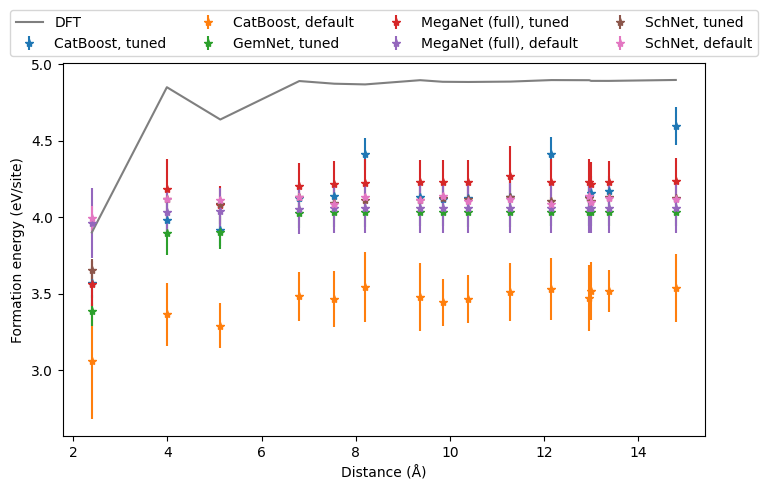

In [158]:
fig, ax = plt.subplots(figsize=(8, 5))
for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
    prediction_mean = family_predictions.groupby(level="_id").mean()
    prediction_std = family_predictions.groupby(level="_id").std()
    ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
ax.set_xlabel("Distance (Å)")
ax.set_ylabel("Formation energy (eV/site)")
plt.tight_layout()
fig.savefig("MoS2_V2.png", dpi=300)